# FluxCourse SIF section (1)

## Introduction

In this section, we will learn the basics of SIF emission from leaves, including:

* Understand the shape of SIF emission (using the data you collected)
* Understand that light intensity as the major control of SIF emission
* Retrieve SIF from an outdoor environment

What we learn here is a mini-version of what has been down with satellite or airborne remote sensing instruments. Hopefully with this hands-on practice you will gain some basic understandings of remote sensing data processing.

## Logistics


You will need to collect the raw digital number from the "SIF magic box" experiment. We will convert these DN to radiance. You will need the following packages. Remember to install the packages using "conda install [package-name]" in your command line:

* seaborn
* pandas
* numpy
* matplotlib
* glob
* xlrd

## Reference

Shameless self-promoting ;)

Yang, X., Shi, H., Stovall, A., Guan, K., Miao, G., Zhang, Y., Zhang, Y., Xiao, X., Ryu, Y. and Lee, J.E., 2018. [FluoSpec 2—An Automated Field Spectroscopy System to Monitor Canopy Solar-Induced Fluorescence.](https://www.mdpi.com/1424-8220/18/7/2063/pdf-vor) Sensors, 18(7), p.2063.

**Import packages (usually the first step in Jupiter Notebook**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob


# import the leaf sif tool I wrote
from leaf_SIF_tools import *

### Let's read one spectra file we've just collected
We will read the spectra, which is in raw DN, uncalibrated. We will then visualize it

In [ ]:
# Change the filename to the file you want to read. Pick one yourself!
filename = '/Users/xiyang/Desktop/FluxCourse/light/QEP013861_16-40-50-489.txt'
# Take a look at the function read_rawspec in leaf_SIF_tools.py
df,ITdf     = read_rawspec(filename)
# Time to plot it
plt.plot(df['wavelength'],df.iloc[:,1])

This is one of the raw fluorescence spectra you just collected! Congratulations! Now, take a look at the spectrum here and summarize what you see.

During the experiment, we collected a lot of spectra, and we also collected some "dark" spectra. The actual signal measured by a spectrometer is the difference between the "light" and "dark" measurements. Let's take a look at them separately, and the calculate the actual signal with them.

In [ ]:
# In this example, I have twenty "light" spectra and ten "dark" spectra. 
# Let's plot "light" spectra
lightfiles      = '/Users/xiyang/Desktop/FluxCourse/light/*.txt'
df2,ITdf2       = read_rawspec(lightfiles)
plt.plot(df2['wavelength'],df2.iloc[:,1:-1])

(1680, 1730)

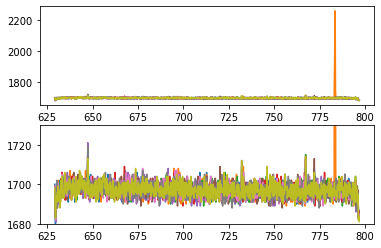

In [35]:
# Let's plot "dark" spectra
darkfiles       = '/Users/xiyang/Desktop/FluxCourse/dark/*.txt'
df3,ITdf3       = read_rawspec(darkfiles)
plt.subplot(2,1,1)
plt.plot(df3['wavelength'],df3.iloc[:,1:-1])
plt.subplot(2,1,2)
plt.plot(df3['wavelength'],df3.iloc[:,1:-1])
plt.ylim([1680,1730])

**What do we see here?**


1) Dark current is the electric noise of the spectrometer, it is fairly constant during measurements (consider the variation in dark current vs. the magnitude and variation of light measurements).

2) There are some pixels that has random yet much bigger noise, but in reality we don't need to worry about it too much.


### Radiometric calibration: converting raw data to values with physical meanings

The next step is essential in most circumstances in remote sensing. We will convert unitless DN values to radiance in the unit of mw/m2/nm/sr, exactly the same as the unit of data from those SIF satellite sensors (OCO-2, TROPOMI etc.) 

Usually this process involves some calibration factor that you get from the manufacturer, or you collect yourself. In this practice I provide you the calibration factor for this spectrometer we are using: "/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx". There are three calibration factors, each in one column of this file, collected under a certain integration time. You can find these integration time in the tab "int_time". Let's plot them.

In [40]:
calib_factor = pd.read_excel('/Users/xiyang/Desktop/FluxCourse/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='cov_cor',header=None)
calib_wl     = pd.read_excel('/Users/xiyang/Desktop/FluxCourse/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='wl',header=None)
calib_int    = pd.read_excel('/Users/xiyang/Desktop/FluxCourse/20190521/QEP013861_20190521_ConversionFactor_L_VEG.xlsx',sheet_name='int_time',header=None)



(0, 0.02)

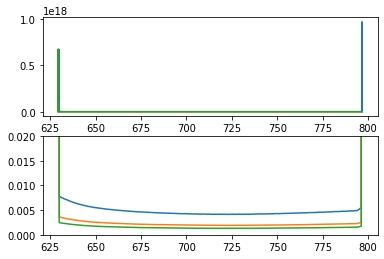

In [42]:
plt.subplot(2,1,1)
plt.plot(calib_wl,calib_factor)
plt.subplot(2,1,2)
plt.plot(calib_wl,calib_factor)
plt.ylim([0,0.02])

**What is going on at the beginning and the end of the spectra??**

Spectrometers are designed in a way that they have some pixels that serve as the "baseline" of the electronic performance of spectrometers, and they are located at the beginning and end of the electronic detectors (pixels). We will exclude them in the future analysis (first 4 and last 4).

**How to convert DN to Radiance??**

DN values (actual signal) are generally linearly correlated with the integration time. That is the longer the integration time, the higher the DN is. Thus we can use the following equation to calculate radiance:

Radiance = (Light - Dark) * (INT1/INT2), where INT1 is the integration time of the actual measurement, where as INT2 is the integration time of the calibration factor. You can pick one of the calibration factors.


